<h1><b>Influenza H1N1 2009 Pandemic in Sweden

# Preliminary parts

## Epidemic on a known graph

In [2]:
import numpy as np
import networkx as nx
from numpy.random import choice, randint
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [3]:
G = nx.random_regular_graph(d=4, n=500, seed=42)
print(f"is connected: {nx.is_connected(G)}")
print(f"is directed: {nx.is_directed(G)}")

is connected: True
is directed: False


<h3><b>Main functions

In [4]:
def print_avg_degree(G):
    degree = 0
    for i in G.nodes:
        degree += G.degree(i)
    degree /= len(G.nodes)
    print(f"Average degree: {degree:.2f}")
    return degree

def generate_preferential_attachment_graph(n_nodes, k):
    """Generates a random SIR graph which follows the preferential attachment rule. Starts with a complete graph of k+1 nodes then adds one node at a time and links it to k/2 nodes
    (if k is odd it links it alternatively to floor(k/2) and ceil(k/2) nodes) chosen accordingly to a probability distribution dictated by the degree of the nodes.

    Args:
        n_nodes (int): the number of nodes in the graph
        k (int): the average degree the nodes will have

    Returns:
        networkx.Graph(): the resulting graph.
    """
    G = nx.complete_graph(k+1)
    i = G.number_of_nodes()
    while i<n_nodes:
        i+=1
        if k%2 == 0:
            c = k/2
        else:
            c = math.floor(k/2) if i % 2 == 0 else math.ceil(k/2) # by doing so, if k is odd, c is alternatively floor(k/2) AND ceil(k/2)

        G = add_node_and_links_preferential_attachment(G,i,c)

    return G

def add_node_and_links_preferential_attachment(G,i,c):
    """Performs the adding of the i-th node and its links. It is a necessary step to the building of the preferential attachment random graph.

    Args:
        G (networkx.Graph()): the graph to which you are adding the node and its links
        i (int): it is the integer which defines the node that is being added at this step
        c (int): the degree the new node will have

    Returns:
        networkx.Graph(): the resulting graph.
    """


    # H will be the returned graph, the one with the additional node and links
    H = G.copy()
    H.add_node(i)

    # degrees are the degrees of the nodes of G, the graph at which we want to add the new node. probs are computed using these degrees. G is what we would denote as H(t-1).
    degrees = [G.degree(j) for j in G.nodes()]
    tot = sum(degrees)
    probs = [d/tot for d in degrees]

    chosen_nodes = np.random.choice(G.nodes, size=int(c), p=probs, replace=False) # 'replace=False' guarantees to not add multiple links to the same node.

    for node in chosen_nodes:
        H.add_edge(i, node)

    return H

def generate_symmetric_k_regular_graph(n_nodes, k):
    """Initialize a symmetric k-regular graph in which nodes can be either Susceptible, Infected or Recovered (SIR)

    Args:
        n_nodes (int): number of nodes in the graph
        k (int): number of neighbors of each node

    Returns:
        networkx.Graph(): The created graph
    """

    G = nx.Graph()
    G.add_nodes_from(list(range(n_nodes)))

    # Add edges based on the specified rule
    for i in range(n_nodes):
        for j in range(1, k // 2 + 1):
            neighbor1 = (i + j) % n_nodes
            neighbor2 = (i - j) % n_nodes
            G.add_edge(i, neighbor1)
            G.add_edge(i, neighbor2)

    return G

def simulate_epidemic_nv(G, num_weeks, infected_array, beta, rho):
    new_infected_list = np.zeros(num_weeks)
    status_counter = np.array([])
    next_infected = infected_array.copy()
    for week in range(num_weeks):
        new_infected = 0
        unique, counts = np.unique(infected_array, return_counts=True)
        if 'R' not in unique:
            unique = np.append(unique, 'R')
            counts = np.append(counts, 0)
        if 'I' not in unique:
            unique = np.append(unique, 'I')
            counts = np.append(counts, 0)

        # each  week I set the counter of S I R like:
        # [{S:.., I:.., R:..},{S:.., I:.., R:..},{},...]
        status_counter = np.append(status_counter, dict(zip(unique, counts)))
        for i in G.nodes:
            m = 0
            if infected_array[i] == 'S':
                for ad in list(G.neighbors(i)):
                    if infected_array[ad] == 'I':
                        m = m+1
                p_infection = 1 - (1-beta)**m
                status = choice(['S', 'I'],p=[1-p_infection, p_infection])


                if status == 'I':
                    new_infected = new_infected + 1

                next_infected[i] = status

            if infected_array[i] == 'I':
                p_recovery = rho
                status = choice(['I', 'R'],p=[1-p_recovery, p_recovery])
                next_infected[i] = status

        # if week == 0:
        #     new_infected_list[week] = num_infected
       # else:
        new_infected_list[week] = new_infected

        infected_array = next_infected.copy()

    return new_infected_list, status_counter


def plot_status_per_week(status_avg, num_simulation, num_weeks, RIS, name = "output.png"):
    x_values = np.arange(1, num_weeks+1)
    plt.figure(figsize=(6, 4), dpi=300)

    for k in RIS:
        plt.plot(x_values, status_avg[k],  label=k, linestyle='-')
    plt.title(f"Total number of SIR individuals at each week under {num_simulation} simulations")
    plt.ylabel('Number of Individuals')

    plt.xticks(x_values, x_values)
    plt.xlabel('Week')
    plt.legend()
    plt.grid()
    plt.savefig("./plots/"+name)
    plt.show()

def plot_newly_infected_per_week(new_infected_avg, new_vaccinated, num_simulation, num_weeks, vax = False, name = "output.png"):
    x_values = np.arange(1, num_weeks+1)

    plt.figure(figsize=(6, 4), dpi=300)

    plt.plot( x_values, new_infected_avg, label='New Infected', linestyle='--')
    if vax:
        plt.plot( x_values, new_vaccinated, label='New Vaccinated', linestyle='--')
        plt.title(f"Newly infected and new vaccinated each week under {num_simulation} simulations")
    else:
        plt.title(f"Newly infected individuals each week under {num_simulation} simulations")
    plt.ylabel('Number of Individuals')
    plt.xlabel('Week')
    plt.xticks(x_values, x_values)
    plt.legend()
    plt.grid()
    plt.savefig("./plots/"+name)
    plt.show()

def get_individual_with_vaccine_per_week(num_nodes, vacc_t):
    vacc_t_f = vacc_t/100
    n_vacc = 0
    n_vacc_t = np.array([], dtype=np.int64)
    for i in range(len(vacc_t_f)):
        n_vacc_t = np.append(n_vacc_t, int(vacc_t_f[i]*num_nodes-n_vacc))
        n_vacc = num_nodes*vacc_t_f[i]
    return n_vacc_t

def get_vacc_id(n_to_be_vaccinated, individuals_nv):
    random_indexes = np.random.choice(individuals_nv, size=n_to_be_vaccinated, replace=False)
    individuals_nv = [value for value in individuals_nv if value not in random_indexes]
    return random_indexes, individuals_nv

def simulate_epidemic(G, n, num_weeks, infected_array, beta, rho, n_vacc_t):
    individuals = list(G.nodes )
    individuals_nv = list(G.nodes) # indv without vax
    vax_ind = np.zeros(n+1) # boolean array, if vax_ind[i] == 1, i has been vaccinated
    n_vax = 0 # add a count var for the infected vaccinated
    np.random.shuffle(individuals) # shuffle the idxs for random iterations among the individuals
    new_infected_list = np.zeros(num_weeks) # list of new infected per week
    status_counter = np.array([]) # array of dicts for the {S: I: ...} each week
    next_infected = infected_array.copy() # array with the status of the ind next week (in this way we do not infect immediately the ind)
    for week in range(num_weeks):
        new_infected = 0

        new_vaccinated, individuals_nv = get_vacc_id(n_vacc_t[week], individuals_nv) #get the idx of the new vax population

        for i in individuals:
            if i in new_vaccinated:
                vax_ind[i] = 1 # update the boolean array, now he can't infect
                if infected_array[i] == 'S': # from S --> V
                    infected_array[i] = 'V'
                    next_infected[i] = 'V'
                else: # else we count a new vaccinated ind, without changing his state: R-->R I-->I
                    n_vax += 1

                pass
            m = 0
            if infected_array[i] == 'S': #check for infections
                for ad in list(G.neighbors(i)):
                    if infected_array[ad] == 'I' and vax_ind[ad]!= 1: # count how many adj ind are infected, just the ones without vax
                        m = m+1
                p_infection = 1 - (1-beta)**m
                status = choice(['S', 'I'],p=[1-p_infection, p_infection]) #chose the new status


                if status == 'I':
                    new_infected = new_infected + 1 # if the new status is I --> we count it as a new infected

                next_infected[i] = status # update next status

            if infected_array[i] == 'I':
                p_recovery = rho
                status = choice(['I', 'R'],p=[1-p_recovery, p_recovery])
                next_infected[i] = status

        new_infected_list[week] = new_infected # update new infected
        unique, counts = np.unique(infected_array, return_counts=True) #creation of a dict from the infected_array

        # this if statemants helps to add the keys that are no/no longer in the infected_array,
        # so if we have no vax for example we add 'V':0
        if 'R' not in unique:
            unique = np.append(unique, 'R')
            counts = np.append(counts, 0)
        if 'S' not in unique:
            unique = np.append(unique, 'S')
            counts = np.append(counts, 0)
        if 'I' not in unique:
            unique = np.append(unique, 'I')
            counts = np.append(counts, 0)
        if 'V' not in unique:
            unique = np.append(unique, 'V')
            counts = np.append(counts, vax_ind.sum()) # we add the other vax
        if 'V'  in unique:
            pos = np.where(unique == 'V')
            counts[pos] += n_vax

         # each  week i put the counter of S I R like
        # [{S:.., I:.., R:..},{S:.., I:.., R:..},{},...]
        status_counter = np.append(status_counter, dict(zip(unique, counts)))

        infected_array = next_infected.copy()

    return new_infected_list, status_counter

def create_params_sets(k_0, beta_0, rho_0, delta_k, delta_beta, delta_rho):
    parameter_sets = []
    for k in [k_0 - delta_k, k_0, k_0 + delta_k]:
        for beta in [beta_0 - delta_beta, beta_0, beta_0 + delta_beta]:
            for rho in [rho_0 - delta_rho, rho_0, rho_0 + delta_rho]:
                parameter_sets.append((k, round(beta,3), round(rho,3)))

    return parameter_sets

def compute_rmse(a, b):
    mse = sum((b[t] - a[t]) ** 2 for t in range(len(a))) / len(a)
    rmse = math.sqrt(mse)
    return round(rmse, 3)

def estimate_H1N1_params(n_nodes, num_infected, n_vacc_t, num_weeks, k_0, beta_0, rho_0, delta_k, delta_beta, delta_rho, truth=[], num_simulation = 10):

    rmse_array = []
    parameter_sets = create_params_sets(k_0, beta_0, rho_0, delta_k, delta_beta, delta_rho)
    new_infected_avg = np.zeros(num_weeks)
    for p_set in tqdm(parameter_sets):
        k = p_set[0]
        beta = p_set[1]
        rho =p_set[2]

        G = generate_preferential_attachment_graph(n_nodes, k)
        infected_array = np.array(['S']*(n_nodes+1))

        for _ in range(num_infected):
            infected_array[randint(0, n_nodes - 1)]='I'

        status_avg = {'R': np.zeros(num_weeks),
                    'I': np.zeros(num_weeks),
                    'S': np.zeros(num_weeks),
                    'V': np.zeros(num_weeks)}

        RIS = ['R', 'I', 'S', 'V']
        for _ in range(num_simulation):
            new_infected, status = simulate_epidemic(G,n_nodes,num_weeks,infected_array,beta,rho, n_vacc_t)
            new_infected_avg = np.add(new_infected_avg, new_infected)
            for k in RIS:
                list_k = [entry[k] for entry in status]
                status_avg[k] = np.add(status_avg[k], list_k)

        new_infected_avg = new_infected_avg/num_simulation
        for k in RIS:
            status_avg[k] = status_avg[k]/num_simulation


        rmse = compute_rmse(new_infected_avg, truth)
        rmse_array.append(rmse)


    best_guess = parameter_sets[np.argmin(rmse_array)]
    print(f"k_0, beta_0, rho_0,: {best_guess}")
    print(f"rmse: {rmse}")

    if best_guess == (k_0, beta_0, rho_0):
        print(best_guess, new_infected_avg, status_avg)
        return best_guess, new_infected_avg, status_avg
    else:
        return estimate_H1N1_params(n_nodes, num_infected, n_vacc_t, num_weeks, best_guess[0], best_guess[1], best_guess[2], delta_k, delta_beta/2, delta_rho/2,  truth, num_simulation)


**Initial configuration with 10 infected nodes selected at random from the node set $\mathcal{V}$**

choice: **SELECT 10 RANDOM NODES**

### 1.1.a  Simulation of a pandemic on a known graph

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


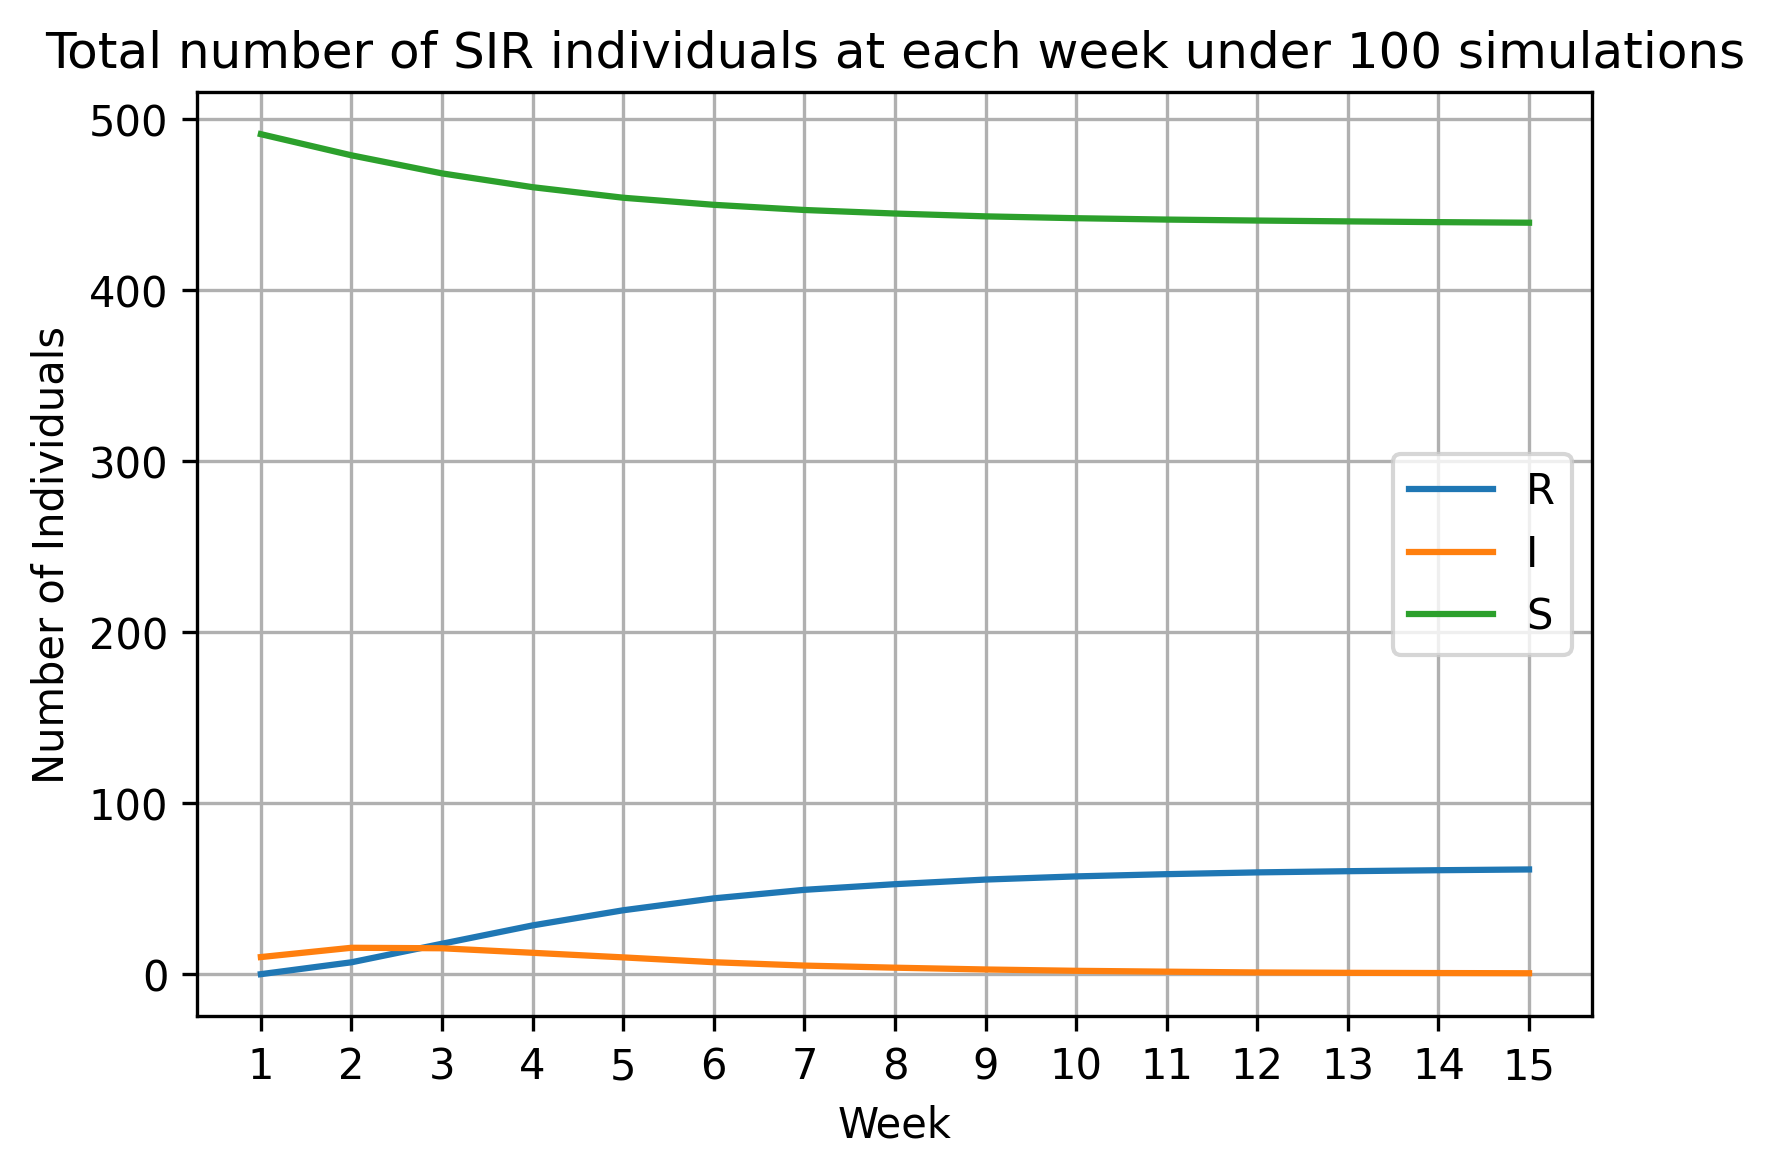

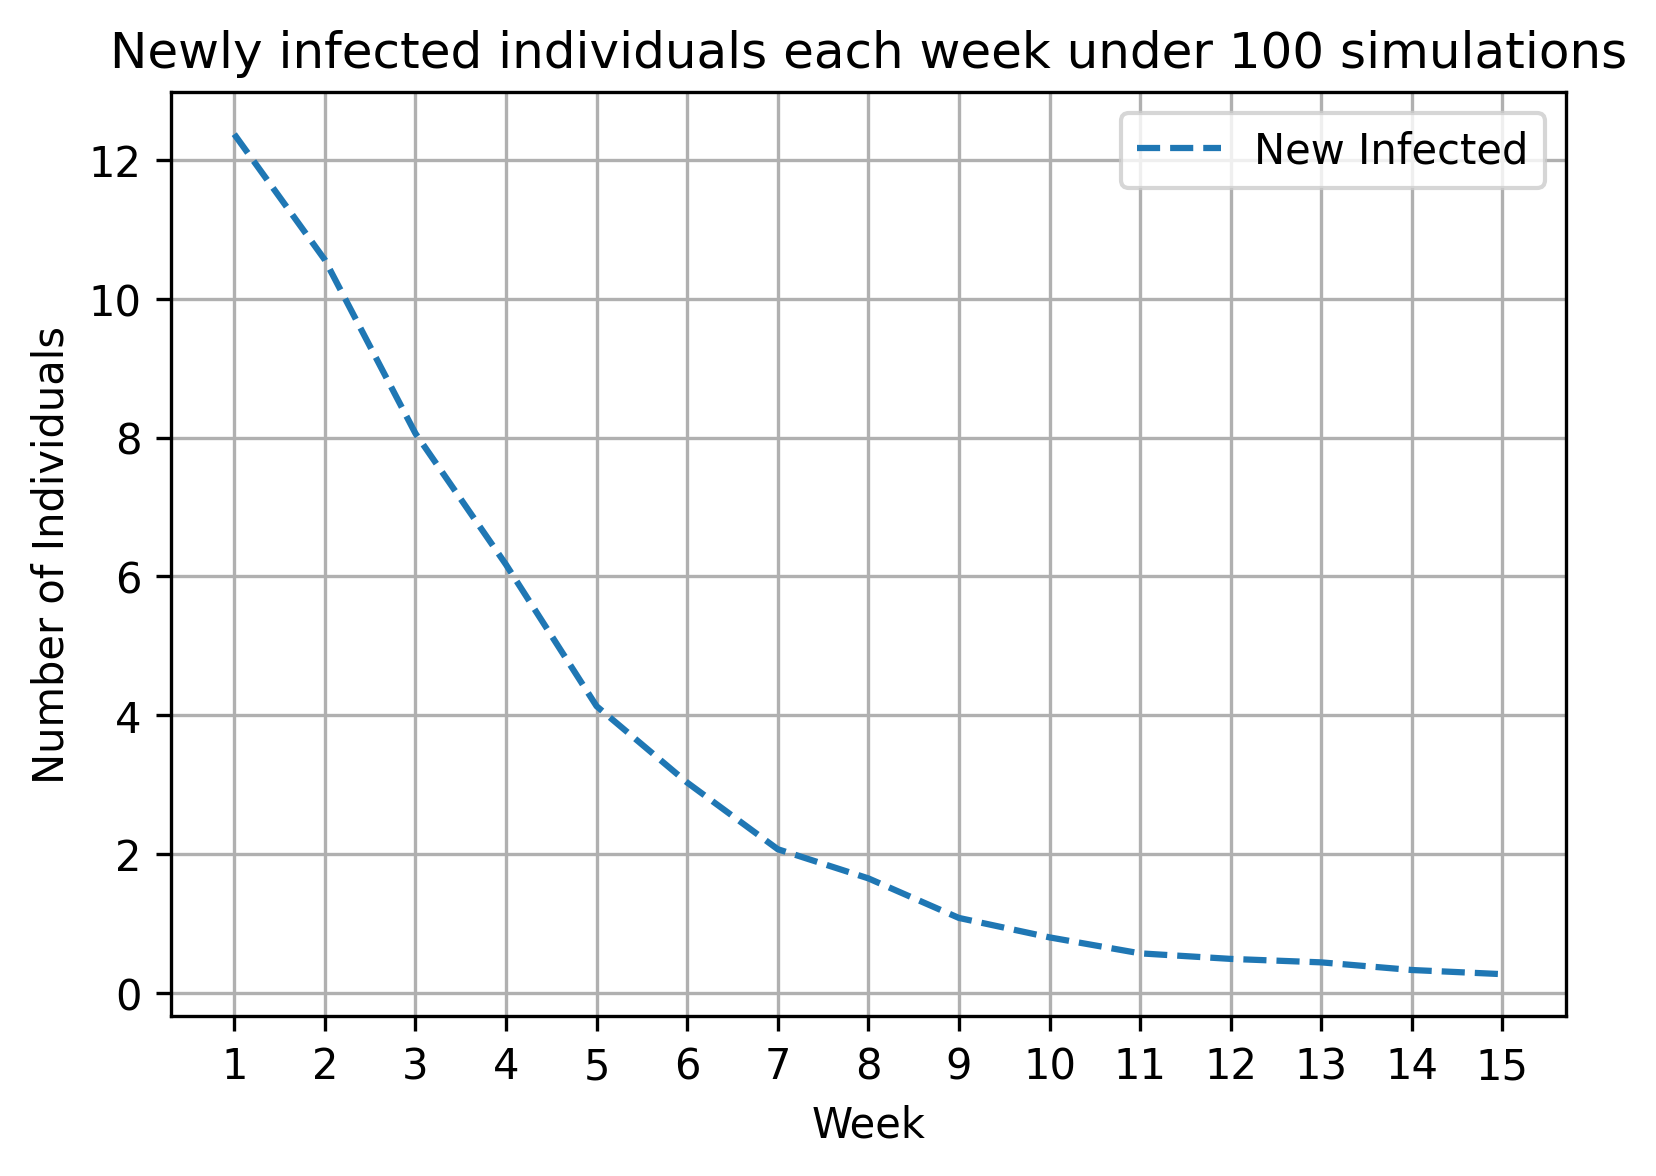

In [5]:
num_nodes = 500
num_weeks = 15
x_values = np.arange(1, num_weeks+1)
k = 4
rho = 0.7
beta = 0.3
num_infected = 10
G=generate_symmetric_k_regular_graph(num_nodes,k)

infected_array = np.array(['S']*(1+num_nodes))

# Infected nodes chosen at random
for i in range(num_infected):
    infected_array[randint(0, num_nodes - 1)]='I'
    
# Simulations
num_simulation = 100
new_infected_avg = np.zeros(num_weeks)

status_avg = {'R': np.zeros(num_weeks),
              'I': np.zeros(num_weeks),
              'S': np.zeros(num_weeks)}
RIS = ['R', 'I', 'S']

for _ in tqdm(range(num_simulation)):
    new_infected, status = simulate_epidemic_nv(G,num_weeks,infected_array,beta,rho)
    new_infected_avg = np.add(new_infected_avg, new_infected)
    for k in RIS:
        list_k = [entry[k] for entry in status]
        status_avg[k] = np.add(status_avg[k], list_k)

new_infected_avg = new_infected_avg/num_simulation
for k in RIS:
    status_avg[k] = status_avg[k]/num_simulation
    
plot_status_per_week(status_avg, num_simulation, num_weeks, RIS, name='simpleG_1_1_1.png')
plot_newly_infected_per_week(new_infected_avg, _ , num_simulation, num_weeks, name='simpleG_1_1_2.png')


## 1.1.b Generation of a random graph with preferential attachment 
900 nodes 

k=6

In [6]:
n = 900
k=6
G = generate_preferential_attachment_graph(n, k)
a = print_avg_degree(G)
print(f'G has {G.number_of_nodes()} nodes')

Average degree: 6.00
G has 900 nodes


## 1.2 Simulate a pandemic over a random graph without vaccination

Average degree: 6.00


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


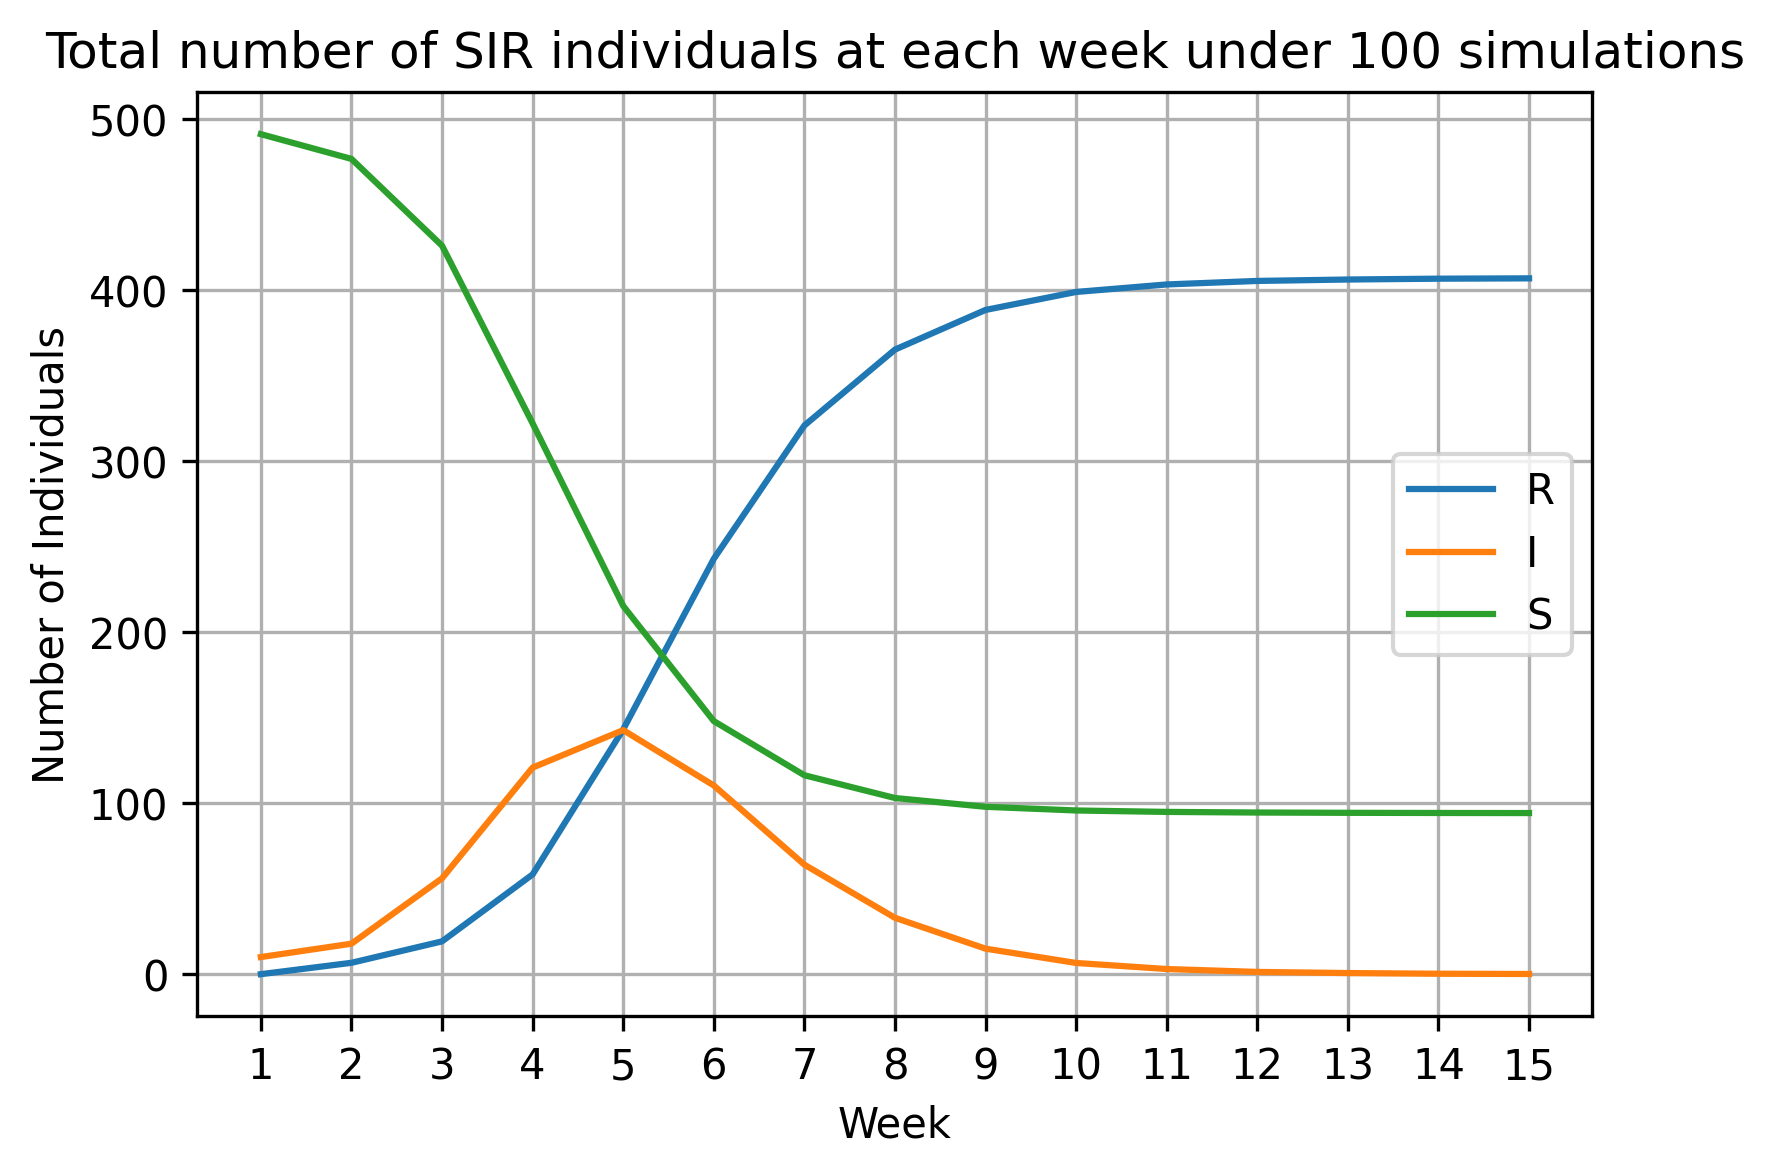

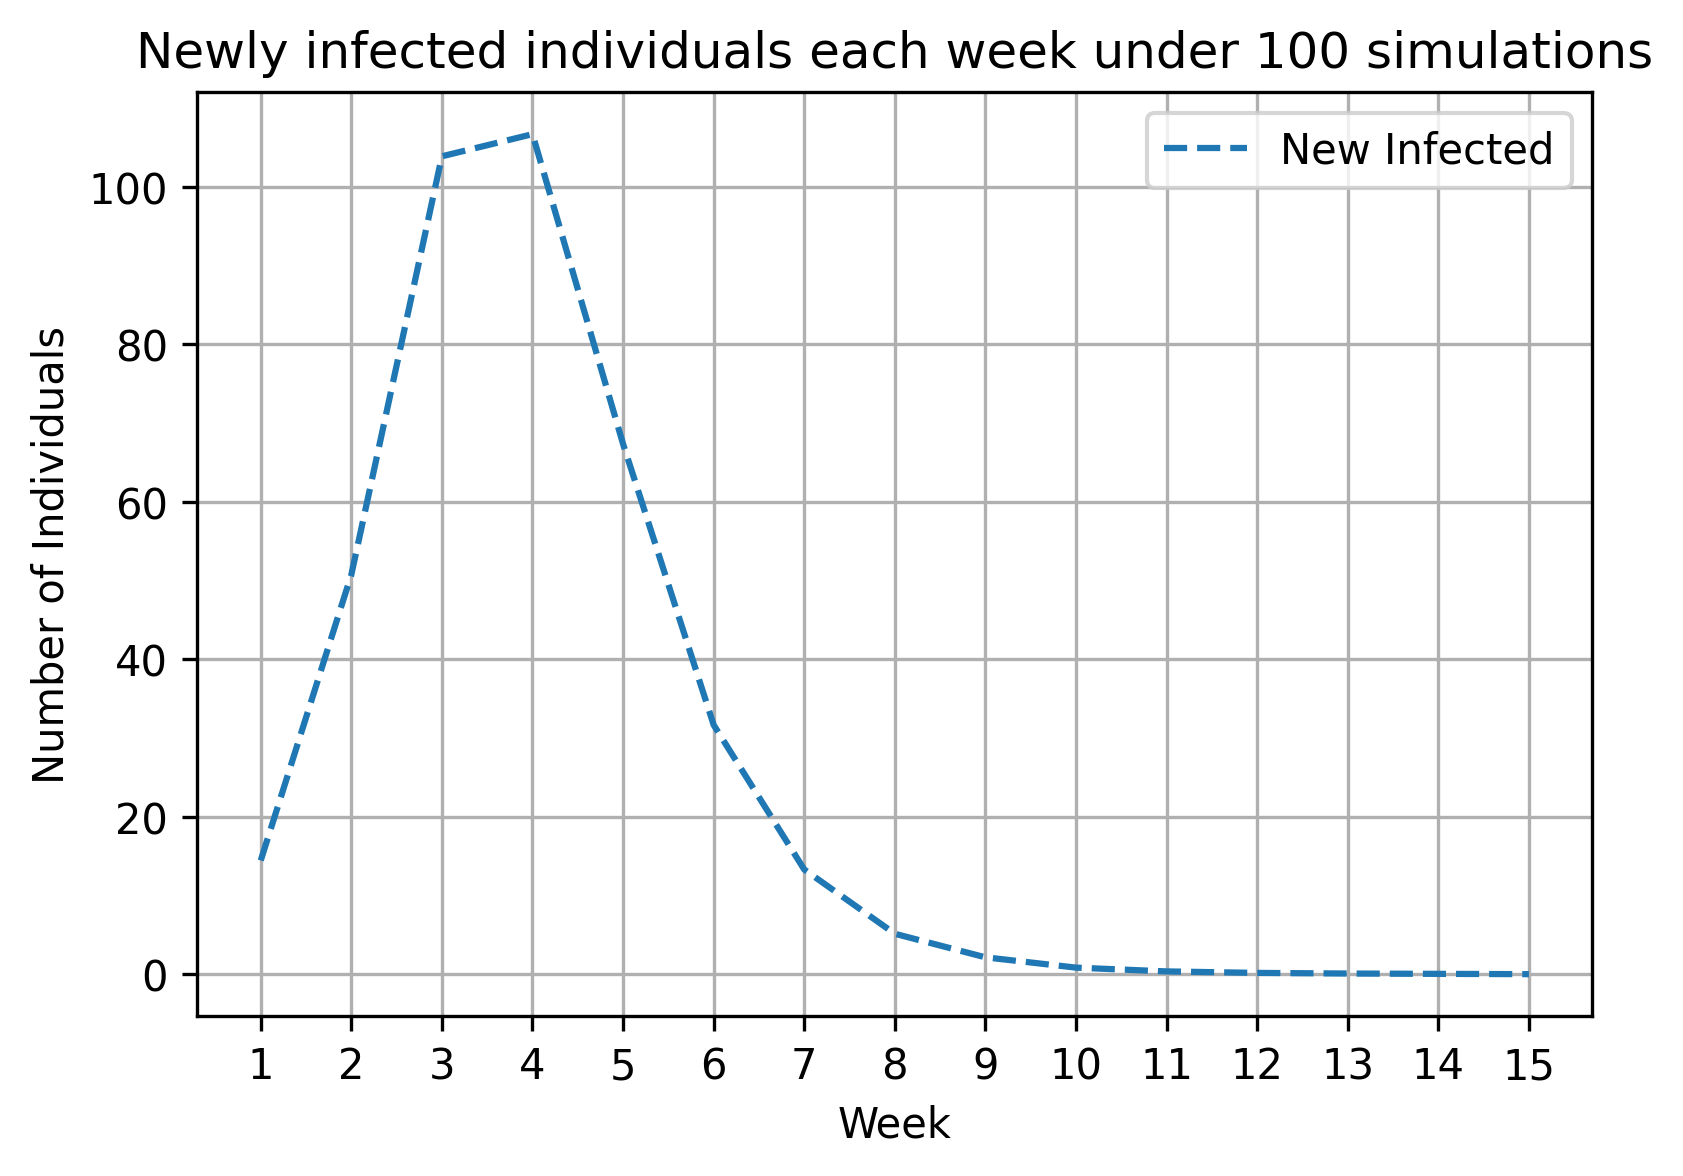

In [7]:
k = 6
beta = 0.3
rho = 0.7
num_weeks = 15
num_infected = 10
num_simulation = 100
num_final_nodes = 500
num_nodes = num_final_nodes
G = generate_preferential_attachment_graph(num_final_nodes, k)
a = print_avg_degree(G)

# Select The Distribution of the infected individuals
infected_array = np.array(['S']*(1+num_nodes))

# Random distribution
for i in range(num_infected):
    infected_array[randint(0, num_nodes - 1)]='I'
    
# Simulations
new_infected_avg_nv = np.zeros(num_weeks)

status_avg_nv = {'R': np.zeros(num_weeks),
              'I': np.zeros(num_weeks),
              'S': np.zeros(num_weeks)}

RIS = ['R', 'I', 'S']
for _ in tqdm(range(num_simulation)):
    new_infected_nv, status = simulate_epidemic_nv(G,num_weeks,infected_array,beta,rho)
    new_infected_avg_nv = np.add(new_infected_avg_nv, new_infected_nv)
    for k in RIS:
        list_k = [entry[k] for entry in status]
        status_avg_nv[k] = np.add(status_avg_nv[k], list_k)

# avg:
new_infected_avg_nv = new_infected_avg_nv/num_simulation
for k in RIS:
    status_avg_nv[k] = status_avg_nv[k]/num_simulation
    

# Plots
plot_status_per_week(status_avg_nv, num_simulation, num_weeks, RIS, name = 'G_nv_1.png')
plot_newly_infected_per_week(new_infected_avg_nv, _, num_simulation, num_weeks, name = 'G_nv_2.png')

## 1.3 Simulation of pandemic over a random graph with vaccinations


Average degree: 6.00


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


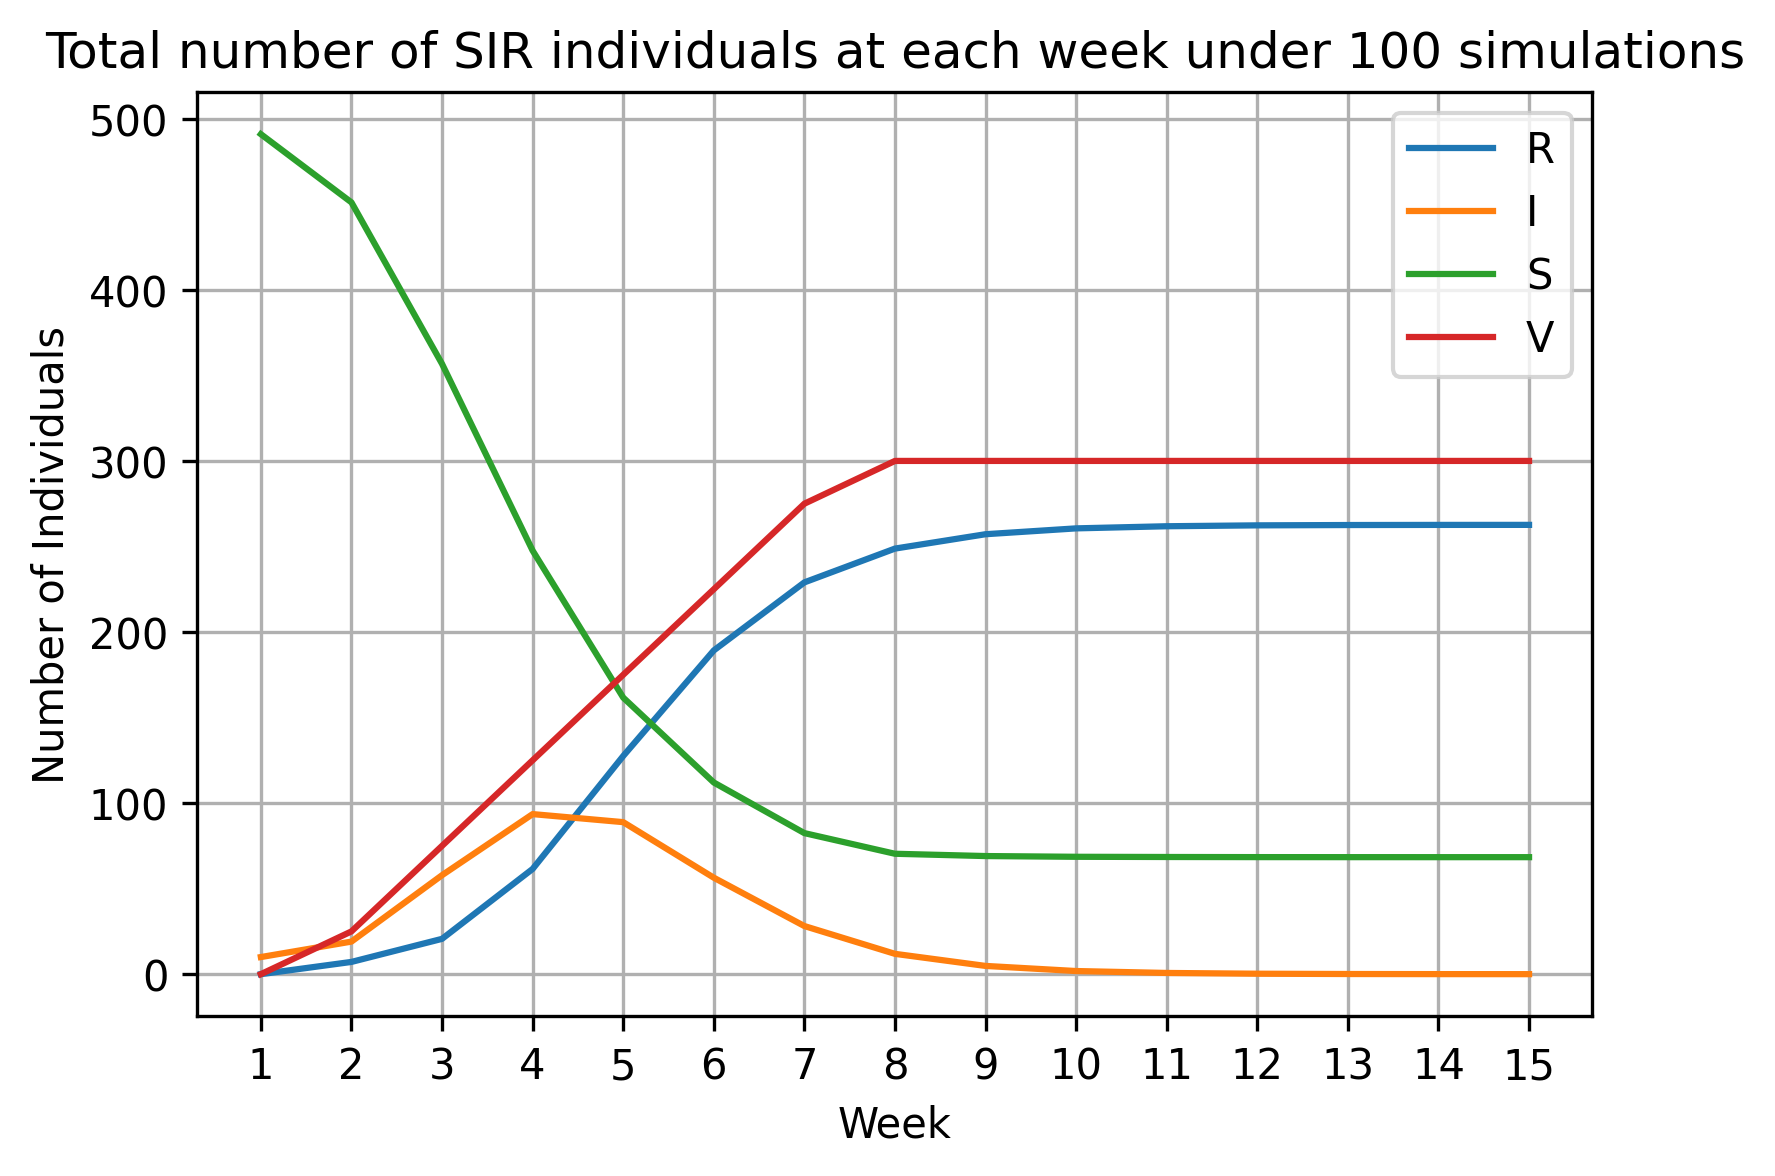

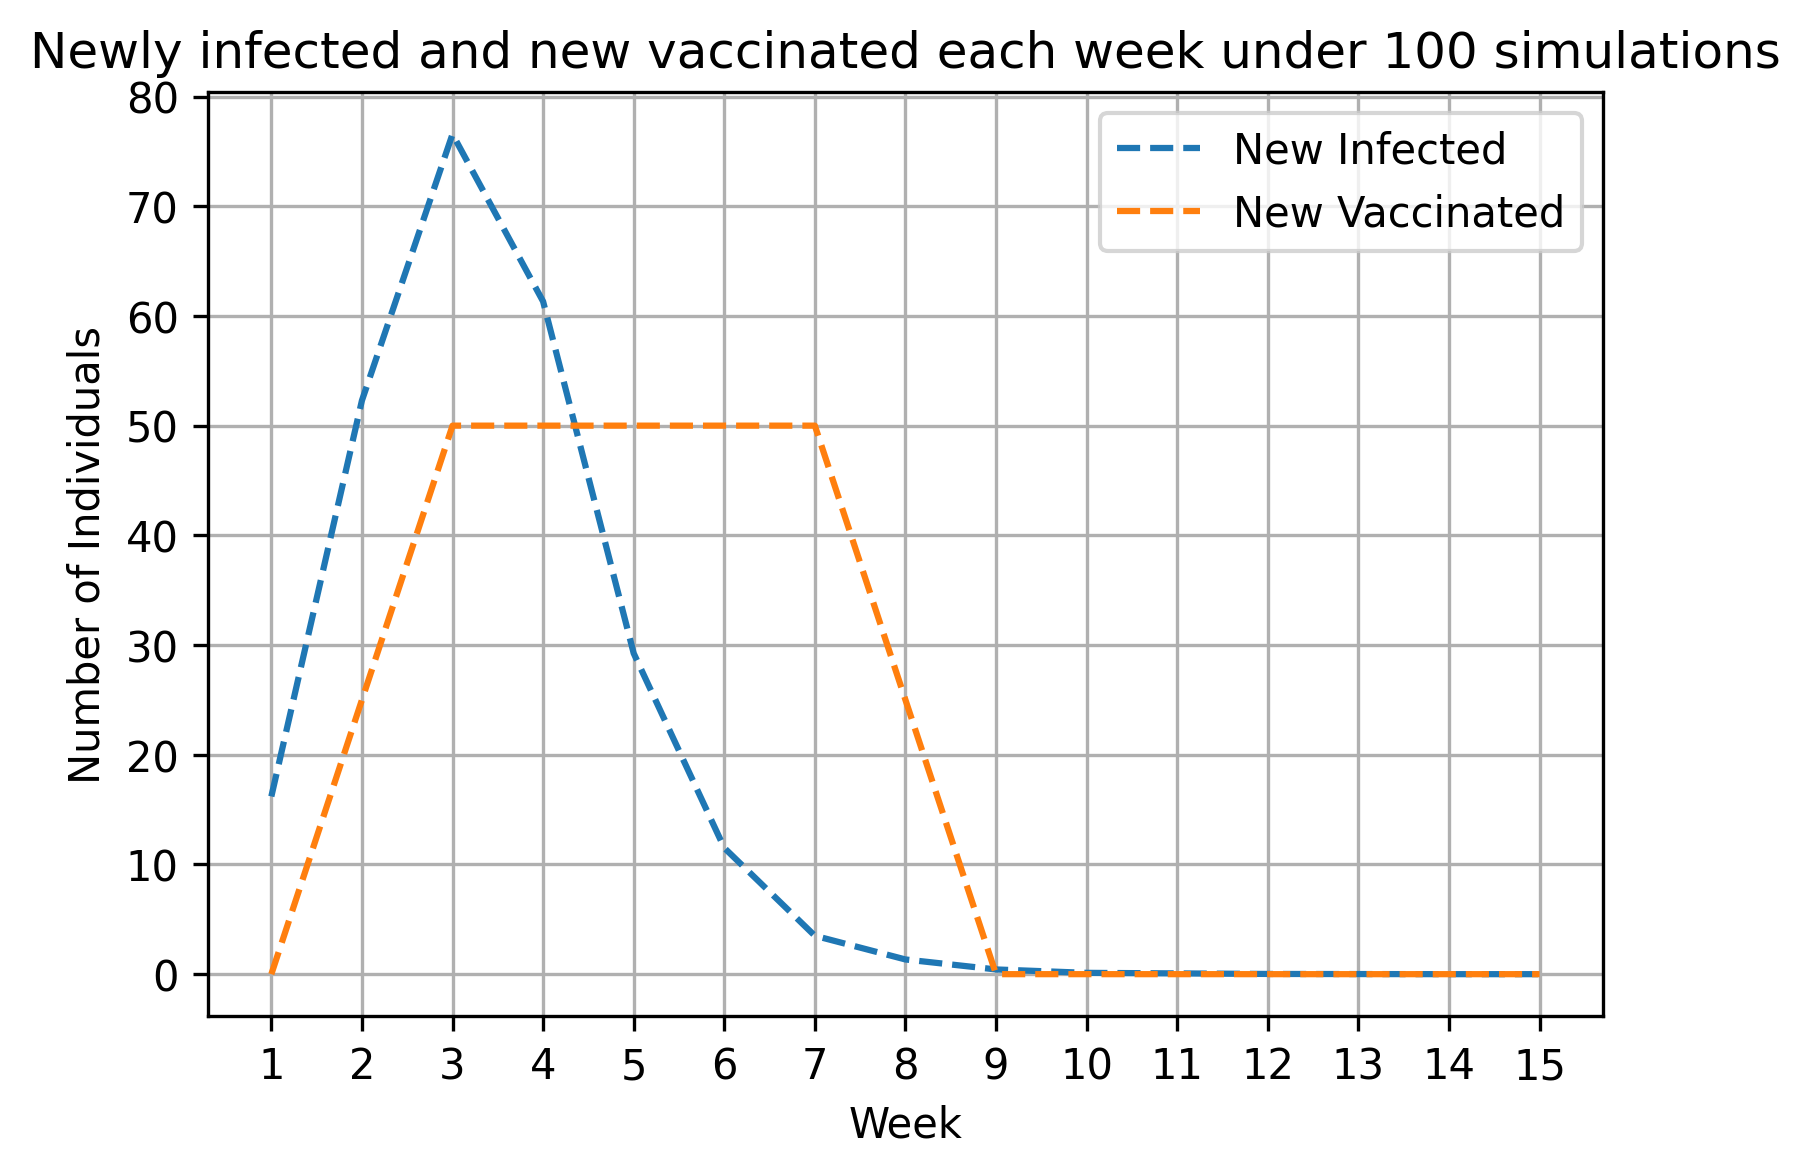

In [8]:
k = 6
beta = 0.3
rho = 0.7
num_weeks = 15
num_infected = 10
num_simulation = 100
num_final_nodes = 500
vacc_t = np.array([0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60])
G = generate_preferential_attachment_graph(num_final_nodes, k)
infected_array = np.array(['S']*(1+num_final_nodes))
for i in range(num_infected):
    infected_array[randint(0, num_final_nodes)]='I'
a = print_avg_degree(G)

n_vacc_t = get_individual_with_vaccine_per_week(num_final_nodes, vacc_t)

num_simulation = 100
new_infected_avg = np.zeros(num_weeks)

status_avg = {'R': np.zeros(num_weeks),
              'I': np.zeros(num_weeks),
              'S': np.zeros(num_weeks),
              'V': np.zeros(num_weeks)}

RIS = ['R', 'I', 'S', 'V']
for _ in tqdm(range(num_simulation)):
    new_infected, status = simulate_epidemic(G,num_final_nodes,num_weeks,infected_array,beta,rho, n_vacc_t)
    new_infected_avg = np.add(new_infected_avg, new_infected)
    # creation of the list ov values for each week
    for k in RIS:
        list_k = [entry[k] for entry in status]
        status_avg[k] = np.add(status_avg[k], list_k)

# avg of the arrays
new_infected_avg = new_infected_avg/num_simulation
for k in RIS:
    status_avg[k] = status_avg[k]/num_simulation
    
# Plots
plot_status_per_week(status_avg, num_simulation, num_weeks, RIS, name='1_3_1.png')
plot_newly_infected_per_week(new_infected_avg, n_vacc_t, num_simulation, num_weeks, vax=True,name='1_3_2.png')

### Comparison Infected individual: with/without vaccine

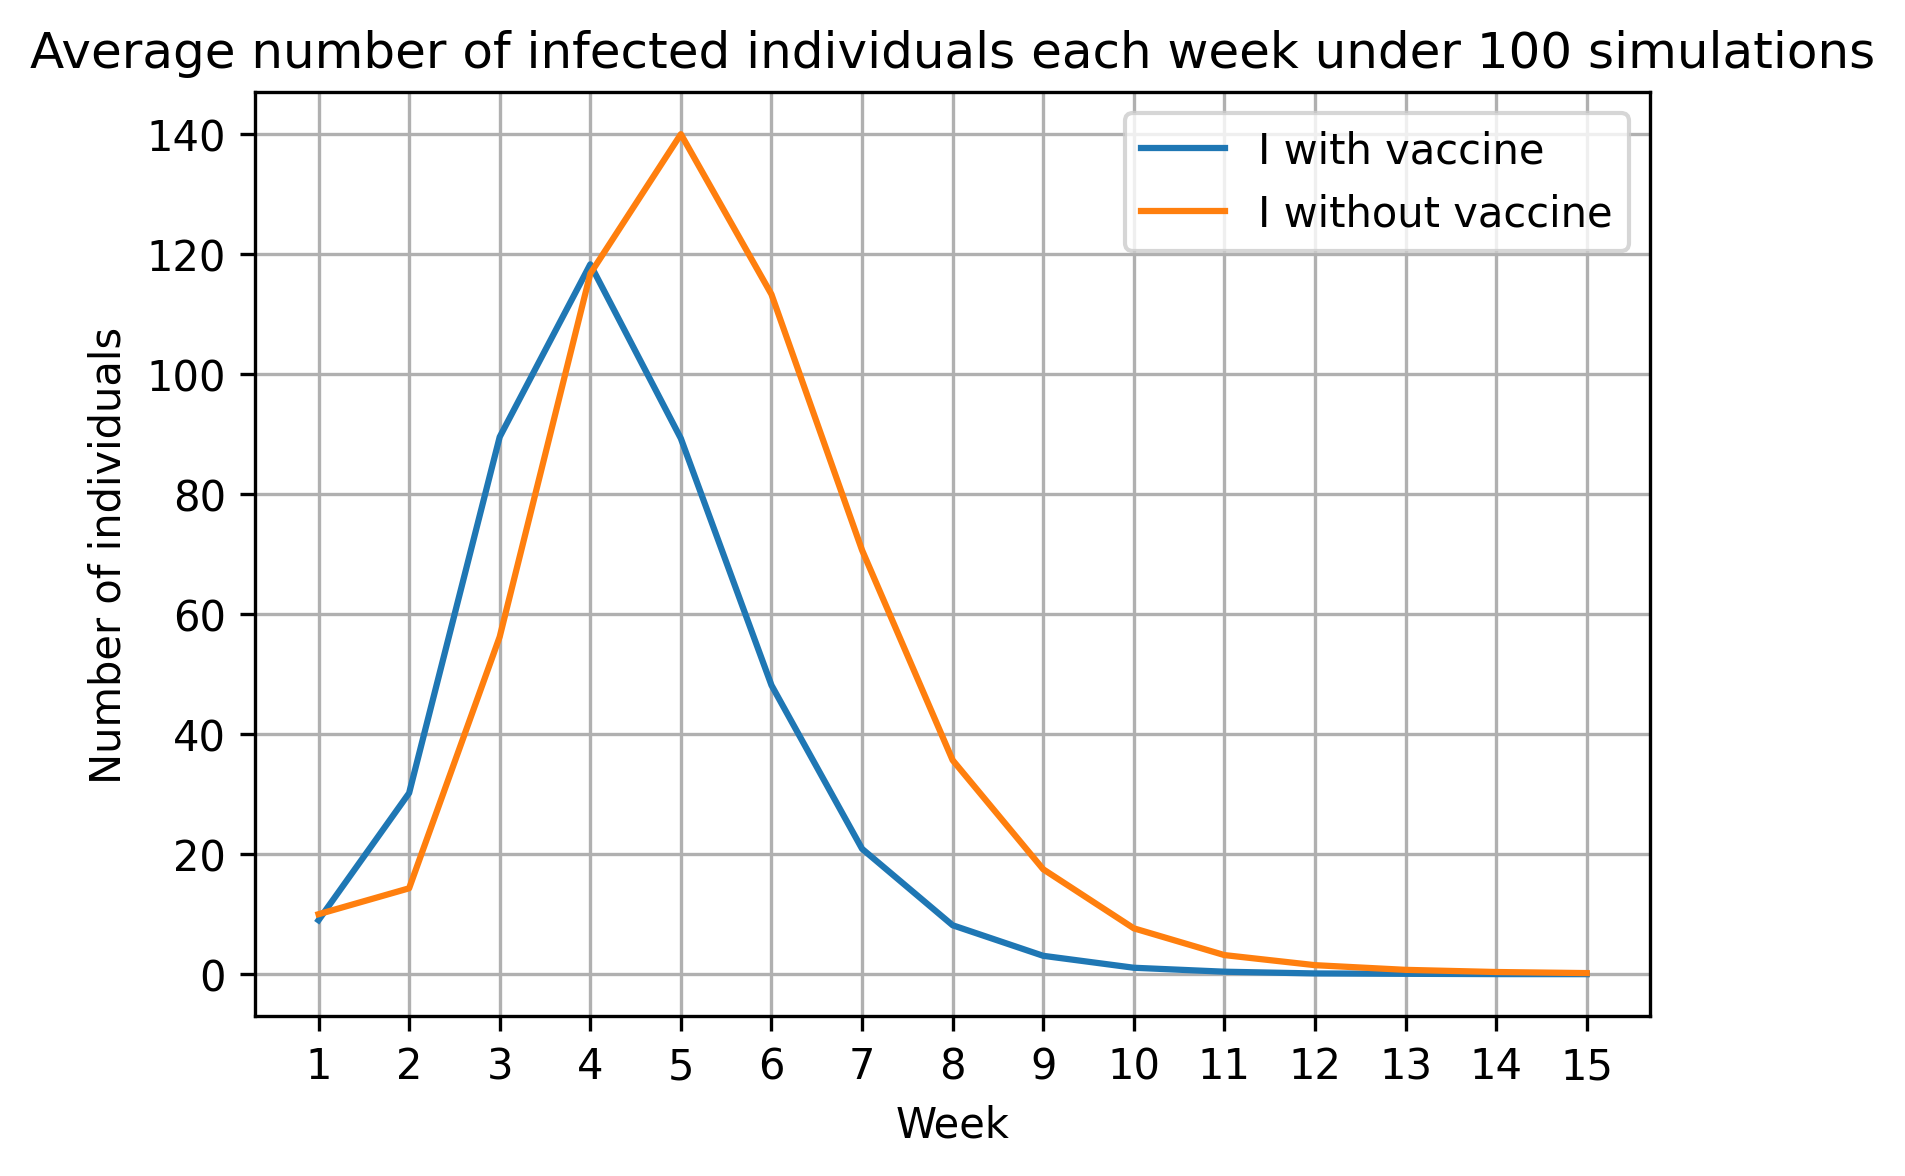

In [12]:
plt.figure(figsize=(6, 4), dpi=300)

plt.plot( x_values, status_avg['I'],  label='I with vaccine', linestyle='-')
plt.plot( x_values, status_avg_nv['I'],  label='I without vaccine', linestyle='-')

plt.title(f"Average number of infected individuals each week under {num_simulation} simulations")
plt.ylabel('Number of individuals')
plt.xticks(x_values, x_values)
plt.xlabel('Week')
plt.legend()
plt.grid()
plt.savefig("./plots/1_3_3.png")
plt.show()

## 1.4 The H1N1 pandemic in Sweden 2009

In [19]:
k_0 = 10
beta_0 = 0.3
rho_0 = 0.6
num_weeks = 15
num_infected = 1
num_simulation = 10
num_final_nodes = 934
num_nodes = num_final_nodes
vacc_t = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
new_infected_zero = np.array([1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
delta_k = 1
delta_beta = 0.1
delta_rho = 0.1
n_vacc_t = get_individual_with_vaccine_per_week(num_nodes, vacc_t)


In [ ]:
best_guess, new_infected_avg, status_avg = estimate_H1N1_params(num_final_nodes,num_infected,n_vacc_t, num_weeks, k_0, beta_0, rho_0, delta_k, delta_beta, delta_rho, truth=new_infected_zero, num_simulation = num_simulation)

In [ ]:
new_infected_avg = [ 0.7783855,   2.45125893,  8.09827951, 12.91675514, 21.83055666, 22.59618801,
                     22.14831188, 18.93465482, 12.72022971,  7.88013351,  4.60562151,  3.75348096,
                     2.25067793,  1.18011342,  0.6401104]
stasus_avg =  {  'R': np.array([  0.,   1.,   3.,   5.,  17.,  47.,  89., 111., 124., 130., 131.,
                    132., 132., 132., 132.]),
                  'I': np.array([10., 10., 10., 24., 45., 63., 39., 26., 16., 10.,  9.,  8.,  8.,
                      8.,  8.]),
                  'S': np.array([838., 816., 774., 722., 650., 577., 532., 514., 511., 511., 511.,
                    511., 511., 511., 511.]),
                  'V': np.array([ 86., 111., 161., 211., 261., 311., 361., 386., 386., 386., 386.,
                    386., 386., 386., 386.])
              }

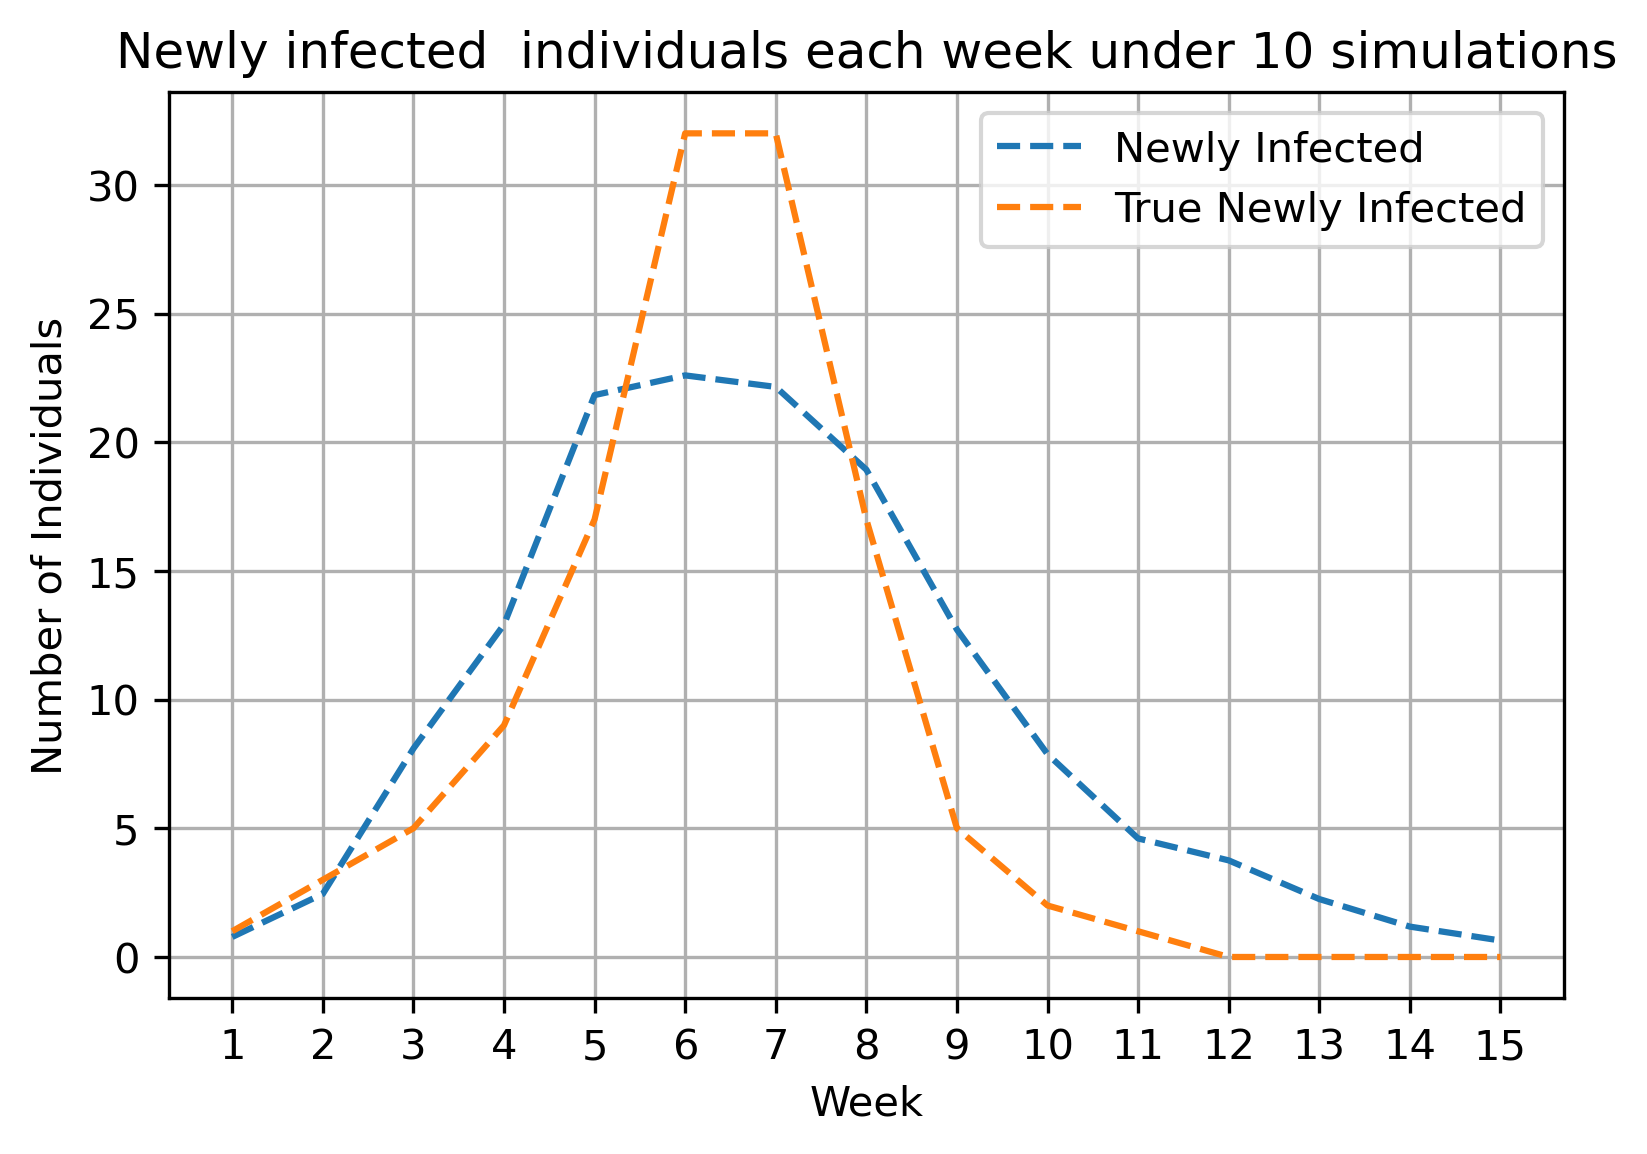

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)

plt.plot( x_values, new_infected_avg, label='Newly Infected', linestyle='--')
plt.plot( x_values, new_infected_zero, label='True Newly Infected', linestyle='--')

plt.title(f"Newly infected  individuals each week under 10 simulations")
plt.ylabel('Number of Individuals')
plt.xticks(x_values, x_values)

plt.xlabel('Week')
plt.legend()
plt.grid()
plt.savefig("./plots/1_4_1.png")
plt.show()


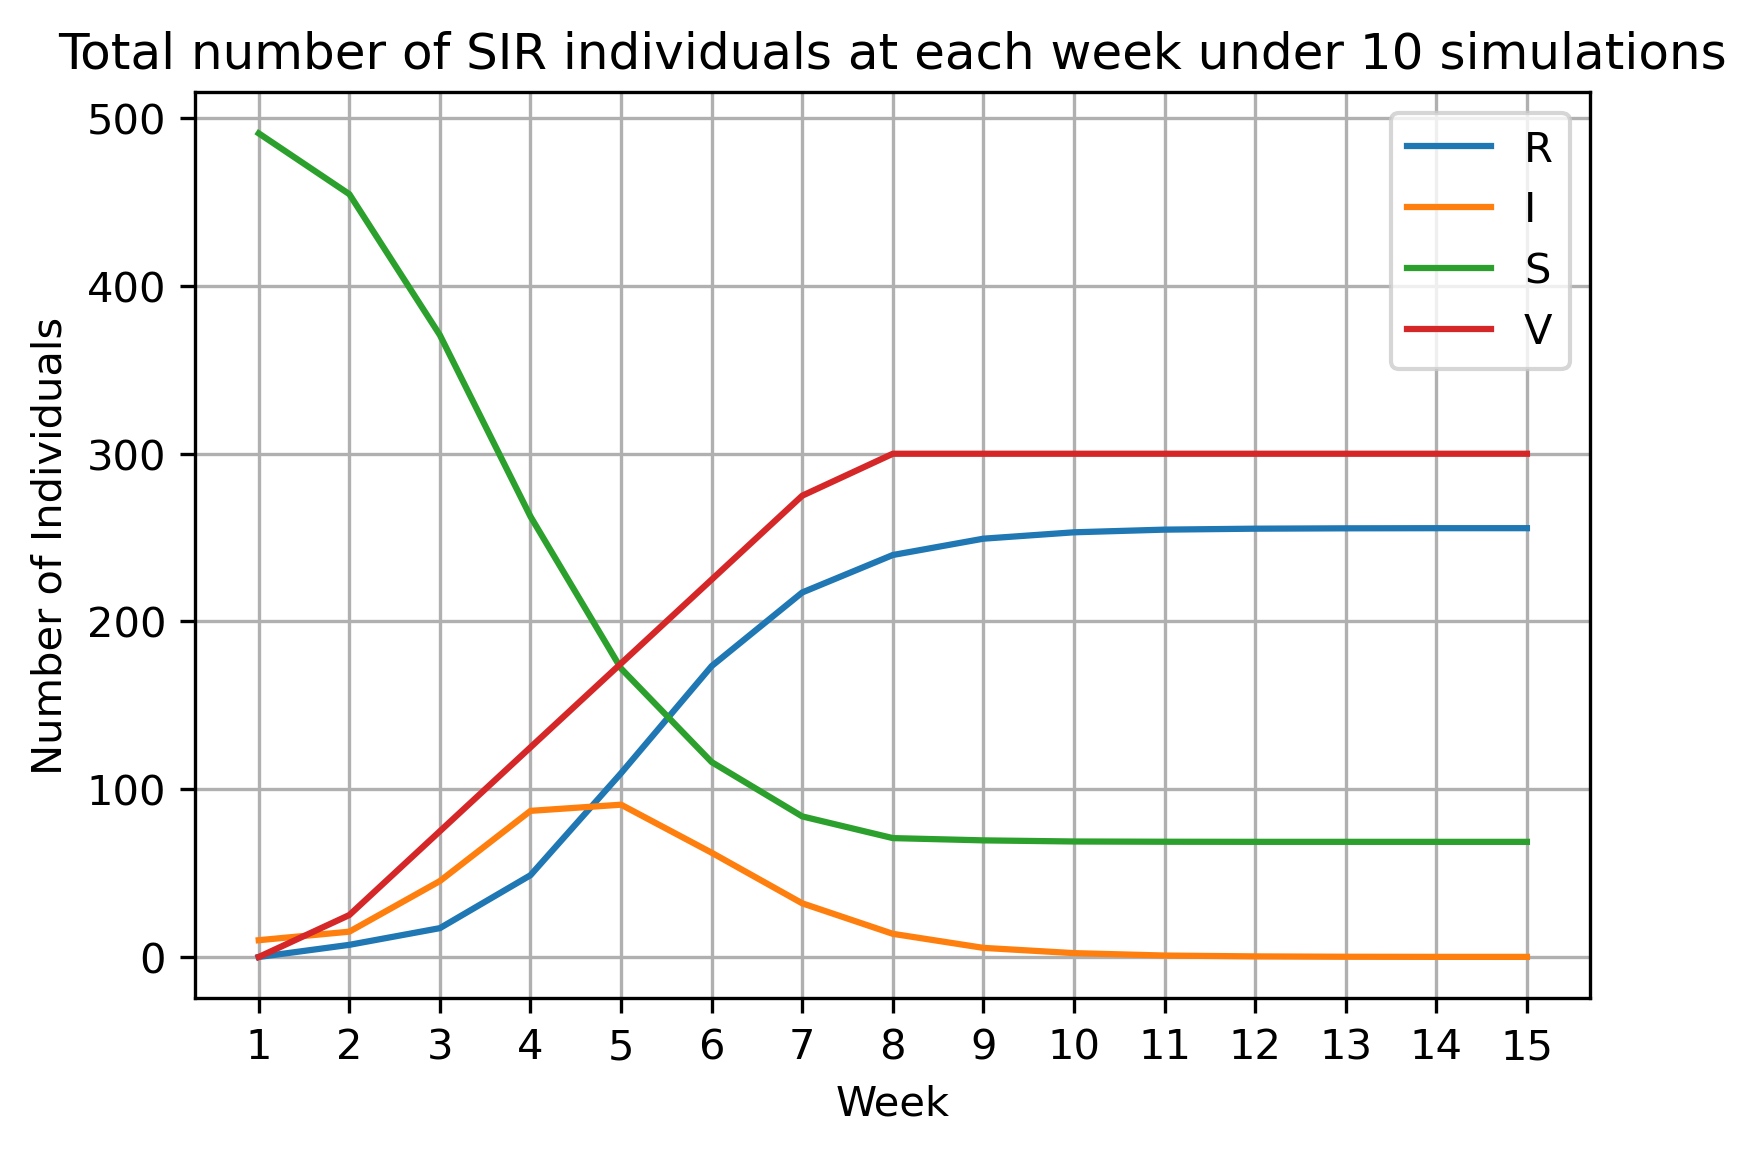

In [ ]:
plot_status_per_week(status_avg, 10, num_weeks, RIS, name="1_4_2.png")

## 1.5 Challenge

In [20]:
def estimate_H1N1_params_ES(n_nodes, num_infected, n_vacc_t, num_weeks, k0, beta, rho, truth=[], num_simulation = 10):

    rmse_array = []
    # parameter_sets = create_params_sets(k_0, beta_0, rho_0, delta_k, delta_beta, delta_rho)
    new_infected_avg = np.zeros(num_weeks)
    k0 = int(k0)
    G = generate_preferential_attachment_graph(n_nodes, k0)
    infected_array = np.array(['S']*(n_nodes+1))
    print('Generated preferential attachment.')
    for _ in range(num_infected):
        infected_array[randint(0, n_nodes - 1)]='I'

    status_avg = {'R': np.zeros(num_weeks),
                'I': np.zeros(num_weeks),
                'S': np.zeros(num_weeks),
                'V': np.zeros(num_weeks)}

    RIS = ['R', 'I', 'S', 'V']
    for _ in range(num_simulation):
        print(f'Simulation: {_ + 1}')
        new_infected, status = simulate_epidemic(G,n_nodes,num_weeks,infected_array,beta,rho, n_vacc_t)
        new_infected_avg = np.add(new_infected_avg, new_infected)
        for k in RIS:
            list_k = [entry[k] for entry in status]
            status_avg[k] = np.add(status_avg[k], list_k)

    new_infected_avg = new_infected_avg/num_simulation
    for k in RIS:
        status_avg[k] = status_avg[k]/num_simulation


    rmse = compute_rmse(new_infected_avg, truth)
    rmse_array.append(rmse)

    print(f"k, beta, rho,: {k0, beta, rho}")
    print(f"rmse: {rmse}")
    return rmse
    # if best_guess == (k_0, beta_0, rho_0):
    #     print(best_guess, new_infected_avg, status_avg)
    #     return best_guess, new_infected_avg, status_avg
    # else:
    #     return estimate_H1N1_params(n_nodes, num_infected, n_vacc_t, num_weeks, best_guess[0], best_guess[1], best_guess[2], delta_k, delta_beta/2, delta_rho/2,  truth, num_simulation)

In [13]:
import matplotlib.pyplot as plt

In [21]:
import random
import numpy as np
from copy import deepcopy

def mutate(ind : np.ndarray, scale : np.ndarray):
    ind += np.array([random.choice([-1, -2, 1, +2]), np.random.normal(scale=scale[0]), np.random.normal(scale=scale[1])])

    if ind[0] == 0:
      ind[0] += 1

    if ind[1] >= 1:
      ind[1] = 1 - np.abs(np.random.normal(scale=0.1))
    elif ind[1] <= 0:
      ind[1] = 0 + np.abs(np.random.normal(scale=0.1))

    if ind[2] >= 1:
      ind[2] = 1 - np.abs(np.random.normal(scale=0.1))
    elif ind[2] <= 0:
      ind[2] = 0 + np.abs(np.random.normal(scale=0.1))

    return ind

POP_SIZE = 3
N_OFFSPRINGS = 12
N_GENERATIONS = 20

std = np.array([0.2, 0.2], dtype=np.float16)
start = np.array([10, 0.3, 0.6], dtype=np.float16)
offsprings = np.zeros((N_OFFSPRINGS, 3), dtype=np.float16)
population = np.zeros((POP_SIZE, 3), dtype=np.float16)
error = []
global_buffer_error = []
global_buffer_best_error = []
global_buffer_population_error = []

for _ in range(N_OFFSPRINGS):
    offsprings[_, :] = mutate(deepcopy(start), std)
    rmse =  estimate_H1N1_params_ES(num_final_nodes, num_infected, n_vacc_t, num_weeks, offsprings[_, :][0], offsprings[_, :][1], offsprings[_, :][2], truth=new_infected_zero, num_simulation = 30)
    error.append(rmse)
    global_buffer_error.append(rmse)

global_buffer_best_error.append(min(error))
best_error = min(error)
best_ind = deepcopy(offsprings[np.argsort(error)[0]])

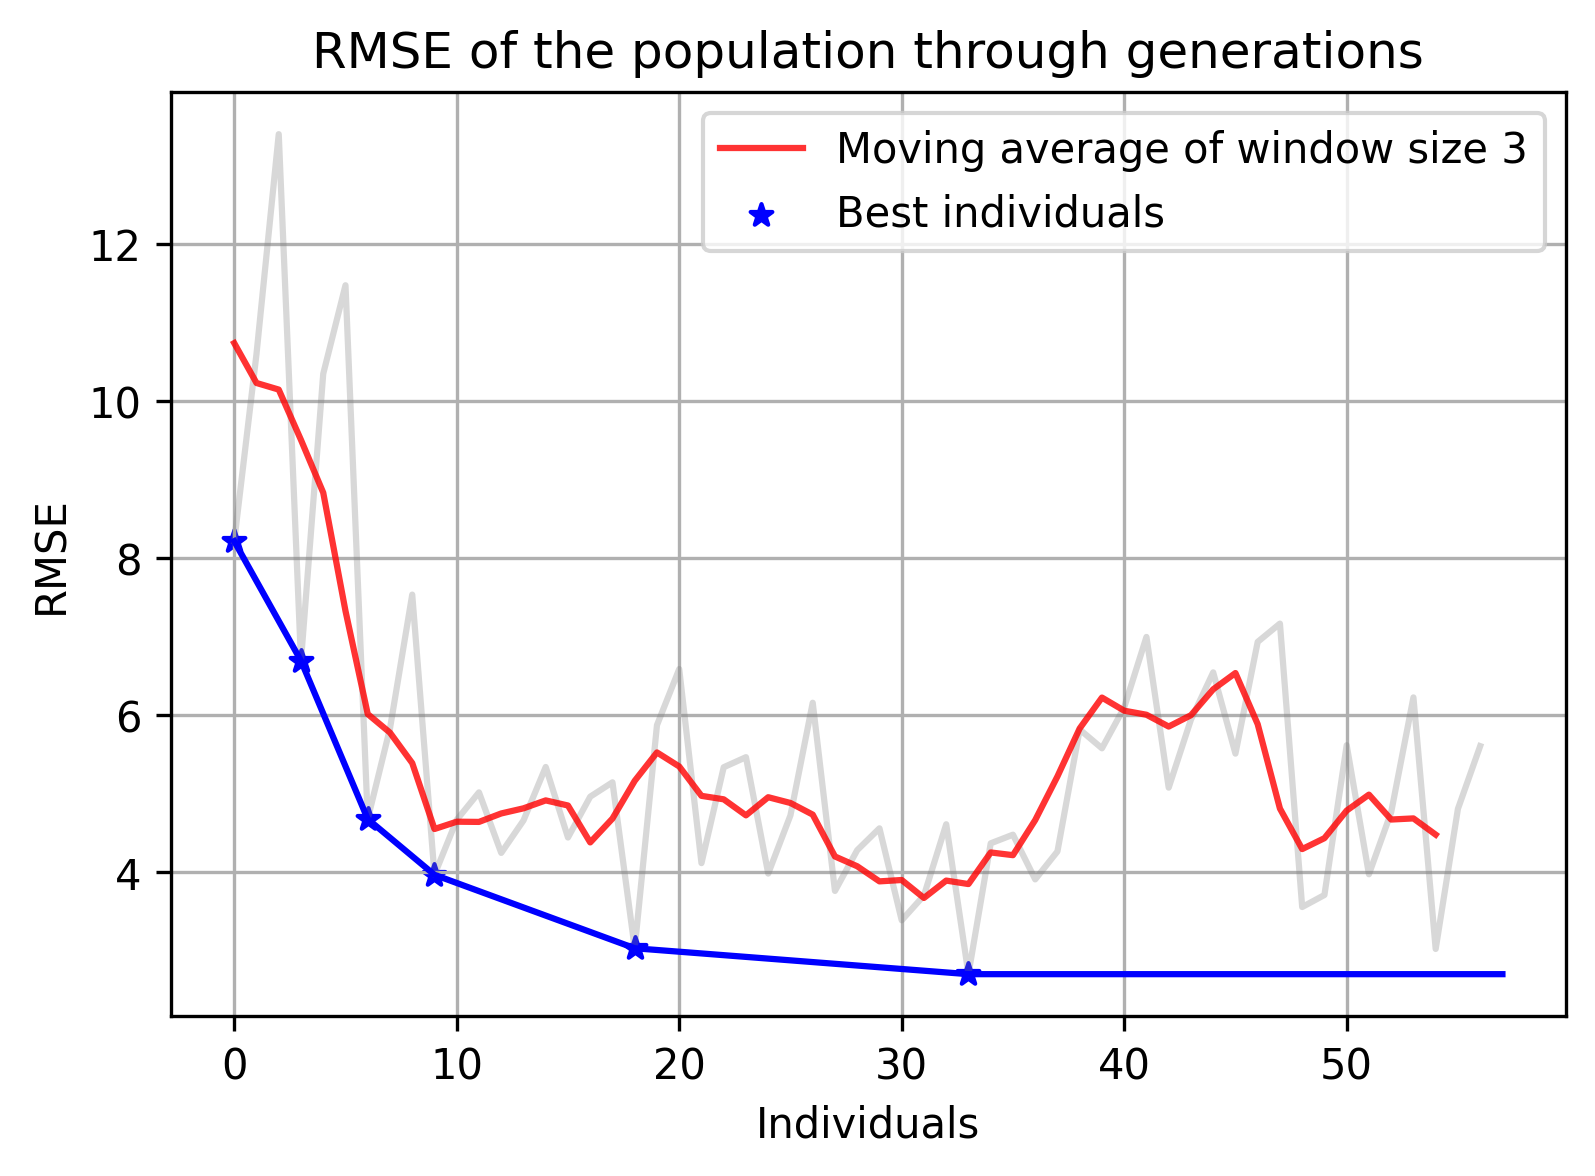

In [113]:
plt.figure(figsize=(6, 4), dpi=300)

plt.plot(global_buffer_population_error, alpha = 0.3, c='grey')
plt.plot(np.convolve(global_buffer_population_error, np.ones(3)/3, mode='valid'), c='red', alpha=0.8, label='Moving average of window size 3')

plt.plot([0, 3, 6, 9, 18, 33, 57],
         [8.217, 6.694, 4.679, 3.969, 3.034, 2.704, 2.704], c='blue')
plt.scatter(0, 8.217, s=30, marker='*', c = 'blue', label='Best individuals')
plt.scatter(3, 6.694, s=30, marker='*', c = 'blue')
plt.scatter(6, 4.679, s=30, marker='*', c = 'blue')
plt.scatter(9, 3.969, s=30, marker='*', c = 'blue')
plt.scatter(18, 3.034, s=30, marker='*', c = 'blue')
plt.scatter(33, 2.704, s=30, marker='*', c = 'blue')

plt.grid()
plt.title(f"RMSE of the population through generations")
plt.ylabel('RMSE')
plt.xlabel('Individuals')
plt.legend()
plt.savefig('ES_rmse.png')
plt.show()


In [22]:
def mutate(ind : np.ndarray, scale : np.ndarray):
    idx = random.choice([0, 1, 2])
    mut = np.array([random.choice([-1, 1]), np.random.normal(scale=scale[0]), np.random.normal(scale=scale[1])])
    ind[idx] += mut[idx]

    # ind += np.array([random.choice([-1, 1]), np.random.normal(scale=scale[0]), np.random.normal(scale=scale[1])])

    if ind[0] == 0:
      ind[0] += 1

    if ind[1] >= 1:
      ind[1] = 1 - np.abs(np.random.normal(scale=0.1))
    elif ind[1] <= 0:
      ind[1] = 0 + np.abs(np.random.normal(scale=0.1))

    if ind[2] >= 1:
      ind[2] = 1 - np.abs(np.random.normal(scale=0.1))
    elif ind[2] <= 0:
      ind[2] = 0 + np.abs(np.random.normal(scale=0.1))

    return ind

for gen in range(N_GENERATIONS):
  print(f'Generation: {gen}')

  population = offsprings[np.argsort(error)[:POP_SIZE]]
  global_buffer_population_error.extend(np.array(error)[np.argsort(error)[:POP_SIZE]])
  error = []

  std_beta = ((0.09 - 0.005) * (1 - gen / N_GENERATIONS) ** (1)) + 0.005
  std_ro = ((0.09 - 0.005) * (1 - gen / N_GENERATIONS) ** (1)) + 0.005
  print(std_beta, std_ro)
  for _ in range(N_OFFSPRINGS):
      offsprings[_] = mutate(deepcopy(random.choice(population)), [std_beta, std_ro])
      error.append(estimate_H1N1_params_ES(num_final_nodes, num_infected, n_vacc_t, num_weeks, offsprings[_, :][0], offsprings[_, :][1], offsprings[_, :][2], truth=new_infected_zero, num_simulation = 30))
      global_buffer_error.append(error[-1])
  if min(error) <= best_error:
      best_error = min(error)
      best_ind = deepcopy(offsprings[np.argsort(error)[0]])
  else:
      offsprings[np.argsort(error)[-1]] = deepcopy(best_ind)
  global_buffer_best_error.append(best_error)

### Last simulation:

``` python
k_0, beta_0, rho_0,: (9, 0.21, 0.56)
rmse: 4.94

k, beta, rho,: (12, 0.1287, 0.7466)
rmse: 4.895

k, beta, rho,: (13, 0.1055, 0.822)
rmse: 4.833

k, beta, rho,: (9, 0.1214, 0.782)
rmse: 4.569

k, beta, rho,: (14, 0.1266, 0.8623)
rmse: 3.834

k, beta, rho,: (9, 0.2656, 0.887)
rmse: 3.579

k, beta, rho,: (10, 0.2152, 0.7925)
rmse: 2.864

k, beta, rho,: (9, 0.2656, 0.887)
rmse: 2.576

k, beta, rho,: (11, 0.1621, 0.646)
rmse: 2.301